In [ ]:
!pip install transformers

In [ ]:
!pip install pytorch-transformers

In [ ]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
nltk.download('punkt')

import torch
from torch import nn
import torch.optim as optim
from transformers import AdamW
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn.functional as F
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix


import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# prepare dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transformer/imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel 

In [ ]:
data.rename(columns = {'processed':'review'}, inplace=True )

In [ ]:
data.head()

,review,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
pre_model = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pre_model, return_dict=False)

In [ ]:
token_lens = []

for txt in data.review:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

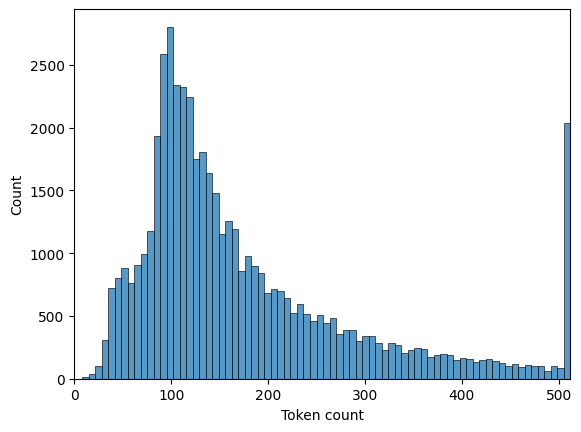

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

# modeling

In [ ]:
max_len = 128

In [ ]:
class IMDb_Dataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [ ]:
from sklearn.model_selection import train_test_split
train_x, remain_x = train_test_split(data, test_size=0.3, random_state=42)
val_x, test_x = train_test_split(remain_x, test_size=0.5, random_state=42)

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 2)
Validation set: (7500, 2)
Test set: (7500, 2)


In [ ]:
def create_data_loader(df, tokenizer, max_len, shuffle, batch_size):
  df = IMDb_Dataset(
    reviews=df.review.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    df,
    shuffle=shuffle,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
batch_size = 16

train_loader = create_data_loader(train_x, tokenizer, max_len, shuffle=True, batch_size=batch_size)
val_loader = create_data_loader(val_x, tokenizer, max_len, shuffle=False, batch_size=batch_size)
test_loader = create_data_loader(test_x, tokenizer, max_len, shuffle=False, batch_size=batch_size)

In [ ]:
data = next(iter(train_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
bert_model = BertModel.from_pretrained(pre_model,return_dict=False)

In [ ]:
# last_hidden_state: 입력에 포함된 모든 토큰의 hidden state를 나타냄
# pooling_output : 전체 시퀀스의 pooling된 표현을 포함

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pre_model)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask,return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_names = ['negative', 'positive']

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = SentimentClassifier(len(class_names)).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)   # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6929, 0.3071],
        [0.7719, 0.2281],
        [0.6453, 0.3547],
        [0.8694, 0.1306],
        [0.8418, 0.1582],
        [0.6598, 0.3402],
        [0.6689, 0.3311],
        [0.7138, 0.2862],
        [0.7828, 0.2172],
        [0.8482, 0.1518],
        [0.7044, 0.2956],
        [0.5864, 0.4136],
        [0.8114, 0.1886],
        [0.8008, 0.1992],
        [0.6627, 0.3373],
        [0.7934, 0.2066]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# training

In [ ]:
grad_clip = 5
epochs = 8

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}

In [ ]:
def train(model, train_loader, optimizer, scheduler, device):

  model = model.train()
  train_acc, train_loss = 0, 0

  for d in train_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    out = model(
      input_ids=input_ids,
      attention_mask=attention_mask)

    _, preds = torch.max(out, dim=1)
    optimizer.zero_grad()
    loss = criterion(out, targets)

    train_acc += torch.sum(preds == targets)
    train_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()

  avg_accuracy = train_acc / (len(train_loader) * train_loader.batch_size)
  avg_loss = train_loss / len(train_loader)

  return avg_loss, avg_accuracy

In [ ]:
def evaluate(model, val_loader, device):

  model = model.eval()
  val_acc, val_loss = 0, 0

  with torch.no_grad():
    for d in val_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      out = model(
        input_ids=input_ids,
        attention_mask=attention_mask)

      _, preds = torch.max(out, dim=1)

      loss = criterion(out, targets)

      val_acc += torch.sum(preds == targets)
      val_loss += loss.item()

  avg_loss = val_loss / len(val_loader)
  avg_accuracy = val_acc / (len(val_loader) * val_loader.batch_size)

  return avg_loss, avg_accuracy

In [ ]:
%%time
val_loss_min = torch.inf
epochs = 8

for e in range(epochs):

  print(f'Epoch {e+1}/{epochs}')
  print('-' * 10)

  train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler, device)
  val_loss, val_accuracy = evaluate(model, val_loader, device)
  history['train_loss'].append(train_loss)
  history['train_acc'].append(train_accuracy)
  history['val_loss'].append(val_loss)
  history['val_acc'].append(val_accuracy)

  print("[EPOCH: %d], Train Loss: %5.2f | Train Accuracy: %5.2f%%" % (e, train_loss, train_accuracy * 100))
  print("[EPOCH: %d], Val Loss: %5.2f | Val Accuracy: %5.2f%%" % (e, val_loss, val_accuracy * 100))


  if val_loss < val_loss_min:
     val_loss_min = val_loss
     torch.save(model.state_dict(), './sentiment_lstm.pt')

Epoch 1/8
----------
[EPOCH: 0], Train Loss:  0.50 | Train Accuracy: 77.83%
[EPOCH: 0], Val Loss:  0.41 | Val Accuracy: 82.97%
Epoch 2/8
----------
[EPOCH: 1], Train Loss:  0.39 | Train Accuracy: 84.60%
[EPOCH: 1], Val Loss:  0.42 | Val Accuracy: 84.24%
Epoch 3/8
----------
[EPOCH: 2], Train Loss:  0.33 | Train Accuracy: 87.02%
[EPOCH: 2], Val Loss:  0.36 | Val Accuracy: 85.83%
Epoch 4/8
----------
[EPOCH: 3], Train Loss:  0.29 | Train Accuracy: 89.32%
[EPOCH: 3], Val Loss:  0.41 | Val Accuracy: 85.06%
Epoch 5/8
----------
[EPOCH: 4], Train Loss:  0.25 | Train Accuracy: 91.06%
[EPOCH: 4], Val Loss:  0.34 | Val Accuracy: 86.75%
Epoch 6/8
----------
[EPOCH: 5], Train Loss:  0.21 | Train Accuracy: 92.77%
[EPOCH: 5], Val Loss:  0.36 | Val Accuracy: 86.98%
Epoch 7/8
----------
[EPOCH: 6], Train Loss:  0.18 | Train Accuracy: 93.96%
[EPOCH: 6], Val Loss:  0.41 | Val Accuracy: 86.77%
Epoch 8/8
----------
[EPOCH: 7], Train Loss:  0.16 | Train Accuracy: 94.88%
[EPOCH: 7], Val Loss:  0.41 | Val A

In [ ]:
history['train_acc']

[tensor(0.7783, device='cuda:0'),
 tensor(0.8460, device='cuda:0'),
 tensor(0.8702, device='cuda:0'),
 tensor(0.8932, device='cuda:0'),
 tensor(0.9106, device='cuda:0'),
 tensor(0.9277, device='cuda:0'),
 tensor(0.9396, device='cuda:0'),
 tensor(0.9488, device='cuda:0')]

In [ ]:
x_data = torch.tensor(history['train_acc'])
x_data.cpu().numpy()

array([0.7783364 , 0.84603524, 0.87017256, 0.8932244 , 0.91062045,
       0.92773086, 0.93958527, 0.9488117 ], dtype=float32)

In [ ]:
y_data = torch.tensor(history['val_acc'])
y_data.cpu().numpy()

array([0.8296909 , 0.8423508 , 0.85834223, 0.850613  , 0.8675373 ,
       0.8698028 , 0.8676706 , 0.8686034 ], dtype=float32)

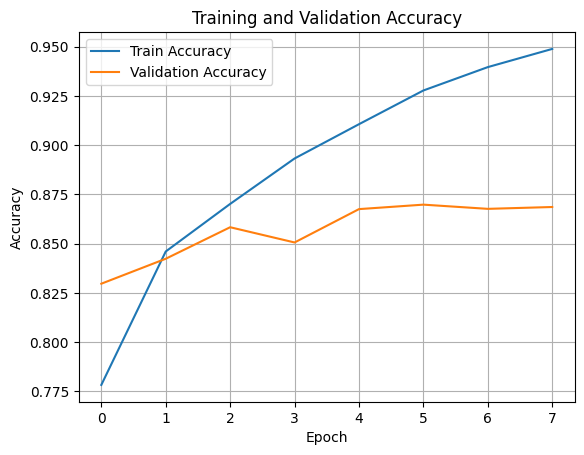

In [ ]:
plt.plot(x_data, label='Train Accuracy')
plt.plot(y_data, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

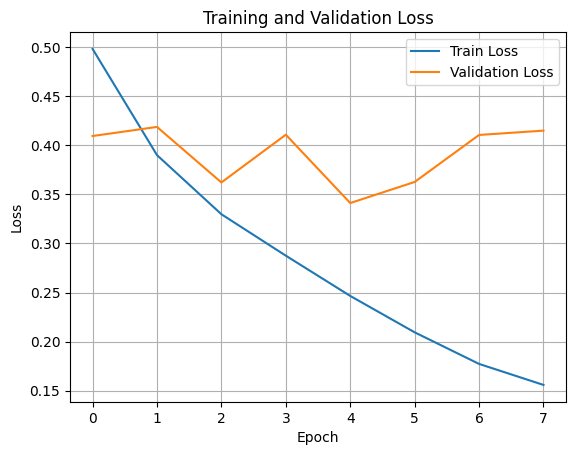

In [ ]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [ ]:
model.eval()

test_acc, test_loss = 0, 0

with torch.no_grad():
    for d in test_loader:
      input_ids = d["input_ids"].cuda()
      attention_mask = d["attention_mask"].cuda()
      targets = d["targets"].cuda()

      out = model(
        input_ids=input_ids,
        attention_mask=attention_mask)

      _, preds = torch.max(out, dim=1)

      loss = criterion(out, targets)

      test_acc += torch.sum(preds == targets)
      test_loss += loss.item()

    print(f'Accuracy: {test_acc/(len(test_loader)* test_loader.batch_size):.5f}, Loss: {test_loss/len(test_loader):.5f}')

Accuracy: 0.87527, Loss: 0.39248
